<a href="https://colab.research.google.com/github/seepala98/EVA-4/blob/master/PHASE_1/S5/Assinment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [58]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0.05

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0)
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [60]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,440
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
             ReLU-10           [-1, 10, 24, 24]               0
      BatchNorm2d-11           [-1, 10, 24, 24]              20
          Dropout-12           [-1, 10, 24, 24]               0
        MaxPool2d-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
#test_losses = []
train_acc = []
#test_acc = []

def train(model, device, train_loader, optimizer, epoch, l1_factor):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if l1_factor > 0:  # Apply L1 regularization
      l1_criteria = nn.L1Loss(size_average=False)
      regularizer_loss = 0
      for parameter in model.parameters():
        regularizer_loss += l1_criteria(parameter, torch.zeros_like(parameter))
      loss += l1_factor * regularizer_loss


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc, incorrect_samples):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            img_batch = data
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            result = pred.eq(target.view_as(pred))

            # Save incorrect samples
            if len(incorrect_samples) < 25:
              for i in range(test_loader.batch_size):
                if not list(result)[i]:
                  incorrect_samples.append({
                      'prediction': list(pred)[i],
                      'label': list(target.view_as(pred))[i],
                      'image': list(img_batch)[i]
                      })
            correct += result.sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
from torch.optim.lr_scheduler import StepLR

def run_model(l_1=0.0, l_2=0.0):
  losses = []
  accuracies = []
  incorrect_samples = []
  
  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95,weight_decay = l_2)
  scheduler = StepLR(optimizer, step_size=5, gamma=0.16)
  epochs = 40

  for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    train(model, device, train_loader, optimizer, epoch, l_1)
    scheduler.step()
    test(model, device, test_loader, losses, accuracies, incorrect_samples)
    
  return losses, accuracies, incorrect_samples

# without l1 and l2

In [63]:
loss, accuracy, incorrect_pred = run_model()

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1:


Loss=0.0323510505259037 Batch_id=468 Accuracy=88.61: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0603, Accuracy: 9832/10000 (98.32%)

Epoch 2:


Loss=0.09112194925546646 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9863/10000 (98.63%)

Epoch 3:


Loss=0.056061893701553345 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:16<00:00, 35.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9902/10000 (99.02%)

Epoch 4:


Loss=0.08160434663295746 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9923/10000 (99.23%)

Epoch 5:


Loss=0.060012172907590866 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:17<00:00, 27.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9928/10000 (99.28%)

Epoch 6:


Loss=0.013717602007091045 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:17<00:00, 26.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)

Epoch 7:


Loss=0.047643426805734634 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 28.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

Epoch 8:


Loss=0.016002437099814415 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:17<00:00, 27.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

Epoch 9:


Loss=0.027423536404967308 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9945/10000 (99.45%)

Epoch 10:


Loss=0.013118411414325237 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9941/10000 (99.41%)

Epoch 11:


Loss=0.052351921796798706 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9945/10000 (99.45%)

Epoch 12:


Loss=0.02827637828886509 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9948/10000 (99.48%)

Epoch 13:


Loss=0.025727683678269386 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 29.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9947/10000 (99.47%)

Epoch 14:


Loss=0.01238104235380888 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9947/10000 (99.47%)

Epoch 15:


Loss=0.01524333655834198 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:15<00:00, 30.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9947/10000 (99.47%)

Epoch 16:


Loss=0.03400332108139992 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9948/10000 (99.48%)

Epoch 17:


Loss=0.018340617418289185 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

Epoch 18:


Loss=0.008022104389965534 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9946/10000 (99.46%)

Epoch 19:


Loss=0.04364695027470589 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

Epoch 20:


Loss=0.04061057046055794 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 31.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9947/10000 (99.47%)

Epoch 21:


Loss=0.06510599702596664 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9946/10000 (99.46%)

Epoch 22:


Loss=0.019318902865052223 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 31.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9946/10000 (99.46%)

Epoch 23:


Loss=0.006828973535448313 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9948/10000 (99.48%)

Epoch 24:


Loss=0.04588742181658745 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 31.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

Epoch 25:


Loss=0.03584451600909233 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9948/10000 (99.48%)

Epoch 26:


Loss=0.0455327183008194 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)

Epoch 27:


Loss=0.003035311819985509 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9945/10000 (99.45%)

Epoch 28:


Loss=0.020159035921096802 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 29.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9947/10000 (99.47%)

Epoch 29:


Loss=0.017178699374198914 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9944/10000 (99.44%)

Epoch 30:


Loss=0.01701756753027439 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9946/10000 (99.46%)

Epoch 31:


Loss=0.005421737674623728 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9945/10000 (99.45%)

Epoch 32:


Loss=0.015466456301510334 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 28.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)

Epoch 33:


Loss=0.016250895336270332 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9948/10000 (99.48%)

Epoch 34:


Loss=0.026690183207392693 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 31.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9947/10000 (99.47%)

Epoch 35:


Loss=0.02386271394789219 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9943/10000 (99.43%)

Epoch 36:


Loss=0.010714004747569561 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 28.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9945/10000 (99.45%)

Epoch 37:


Loss=0.006901124957948923 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9948/10000 (99.48%)

Epoch 38:


Loss=0.018029863014817238 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9944/10000 (99.44%)

Epoch 39:


Loss=0.06098252907395363 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 27.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9946/10000 (99.46%)

Epoch 40:


Loss=0.03102271258831024 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 28.15it/s]



Test set: Average loss: 0.0178, Accuracy: 9943/10000 (99.43%)



# with l1

In [65]:
l1_loss, l1_accuracy, incorrect_pred_l1 = run_model(l_1=0.0005)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1:


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.323961466550827 Batch_id=468 Accuracy=88.39: 100%|██████████| 469/469 [00:18<00:00, 24.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0900, Accuracy: 9742/10000 (97.42%)

Epoch 2:


Loss=0.2384473979473114 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:17<00:00, 26.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0620, Accuracy: 9824/10000 (98.24%)

Epoch 3:


Loss=0.2325538694858551 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:19<00:00, 24.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0639, Accuracy: 9804/10000 (98.04%)

Epoch 4:


Loss=0.2557854950428009 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:19<00:00, 24.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9857/10000 (98.57%)

Epoch 5:


Loss=0.3350089192390442 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:18<00:00, 24.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9848/10000 (98.48%)

Epoch 6:


Loss=0.18289591372013092 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:18<00:00, 25.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9908/10000 (99.08%)

Epoch 7:


Loss=0.2555387318134308 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:18<00:00, 25.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9921/10000 (99.21%)

Epoch 8:


Loss=0.2073720395565033 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:18<00:00, 25.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9922/10000 (99.22%)

Epoch 9:


Loss=0.1524653285741806 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:18<00:00, 25.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9912/10000 (99.12%)

Epoch 10:


Loss=0.1905529946088791 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:18<00:00, 33.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9899/10000 (98.99%)

Epoch 11:


Loss=0.14572696387767792 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 25.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

Epoch 12:


Loss=0.14377887547016144 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:18<00:00, 31.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9934/10000 (99.34%)

Epoch 13:


Loss=0.1884438842535019 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9938/10000 (99.38%)

Epoch 14:


Loss=0.1382215917110443 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:18<00:00, 25.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9936/10000 (99.36%)

Epoch 15:


Loss=0.13454221189022064 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:18<00:00, 25.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9935/10000 (99.35%)

Epoch 16:


Loss=0.15646323561668396 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 24.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9931/10000 (99.31%)

Epoch 17:


Loss=0.13501642644405365 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:18<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9932/10000 (99.32%)

Epoch 18:


Loss=0.1407129466533661 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:18<00:00, 25.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9930/10000 (99.30%)

Epoch 19:


Loss=0.1597575843334198 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9933/10000 (99.33%)

Epoch 20:


Loss=0.15004269778728485 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 26.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9931/10000 (99.31%)

Epoch 21:


Loss=0.21785011887550354 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:18<00:00, 25.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9934/10000 (99.34%)

Epoch 22:


Loss=0.15587790310382843 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:19<00:00, 24.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9931/10000 (99.31%)

Epoch 23:


Loss=0.15141260623931885 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:18<00:00, 26.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9936/10000 (99.36%)

Epoch 24:


Loss=0.1818486899137497 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:17<00:00, 27.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9936/10000 (99.36%)

Epoch 25:


Loss=0.13408537209033966 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 26.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9932/10000 (99.32%)

Epoch 26:


Loss=0.13758595287799835 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9934/10000 (99.34%)

Epoch 27:


Loss=0.14417698979377747 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9934/10000 (99.34%)

Epoch 28:


Loss=0.14100053906440735 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:18<00:00, 25.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9931/10000 (99.31%)

Epoch 29:


Loss=0.1495625078678131 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:18<00:00, 25.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9938/10000 (99.38%)

Epoch 30:


Loss=0.14076489210128784 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:18<00:00, 31.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9935/10000 (99.35%)

Epoch 31:


Loss=0.1705249398946762 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:19<00:00, 24.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9933/10000 (99.33%)

Epoch 32:


Loss=0.1581605076789856 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:18<00:00, 25.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9934/10000 (99.34%)

Epoch 33:


Loss=0.13732320070266724 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:18<00:00, 30.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9931/10000 (99.31%)

Epoch 34:


Loss=0.1284971982240677 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9932/10000 (99.32%)

Epoch 35:


Loss=0.13645876944065094 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:18<00:00, 25.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9931/10000 (99.31%)

Epoch 36:


Loss=0.16792510449886322 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:17<00:00, 26.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9933/10000 (99.33%)

Epoch 37:


Loss=0.13275769352912903 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 26.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9933/10000 (99.33%)

Epoch 38:


Loss=0.1477394700050354 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:18<00:00, 25.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9933/10000 (99.33%)

Epoch 39:


Loss=0.151433527469635 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:18<00:00, 30.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9935/10000 (99.35%)

Epoch 40:


Loss=0.13109108805656433 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s]



Test set: Average loss: 0.0185, Accuracy: 9933/10000 (99.33%)



# with l2 

In [66]:
l2_loss, l2_accuracy, incorrect_pred_l2 = run_model(l_2=0.0005)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1:


Loss=0.14598961174488068 Batch_id=468 Accuracy=89.38: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0583, Accuracy: 9840/10000 (98.40%)

Epoch 2:


Loss=0.08164185285568237 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:17<00:00, 26.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9909/10000 (99.09%)

Epoch 3:


Loss=0.04089615121483803 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:16<00:00, 28.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9881/10000 (98.81%)

Epoch 4:


Loss=0.03390832245349884 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:16<00:00, 28.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9909/10000 (99.09%)

Epoch 5:


Loss=0.042319294065237045 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9922/10000 (99.22%)

Epoch 6:


Loss=0.043458566069602966 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 32.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9939/10000 (99.39%)

Epoch 7:


Loss=0.020110780373215675 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:17<00:00, 27.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9942/10000 (99.42%)

Epoch 8:


Loss=0.01788952387869358 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 27.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9946/10000 (99.46%)

Epoch 9:


Loss=0.010447184555232525 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:17<00:00, 26.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9946/10000 (99.46%)

Epoch 10:


Loss=0.021134227514266968 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 27.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9944/10000 (99.44%)

Epoch 11:


Loss=0.019721413031220436 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:17<00:00, 27.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9948/10000 (99.48%)

Epoch 12:


Loss=0.01642351783812046 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9946/10000 (99.46%)

Epoch 13:


Loss=0.020280906930565834 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9945/10000 (99.45%)

Epoch 14:


Loss=0.055198684334754944 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9947/10000 (99.47%)

Epoch 15:


Loss=0.007791206240653992 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 27.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9947/10000 (99.47%)

Epoch 16:


Loss=0.022816350683569908 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 27.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9949/10000 (99.49%)

Epoch 17:


Loss=0.02133343555033207 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9948/10000 (99.48%)

Epoch 18:


Loss=0.013829509727656841 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 30.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9946/10000 (99.46%)

Epoch 19:


Loss=0.06231122091412544 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 28.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9946/10000 (99.46%)

Epoch 20:


Loss=0.028197577223181725 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 34.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9946/10000 (99.46%)

Epoch 21:


Loss=0.017766913399100304 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9945/10000 (99.45%)

Epoch 22:


Loss=0.03818748891353607 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9949/10000 (99.49%)

Epoch 23:


Loss=0.13667282462120056 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9946/10000 (99.46%)

Epoch 24:


Loss=0.08513285964727402 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 28.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9948/10000 (99.48%)

Epoch 25:


Loss=0.012469221837818623 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 28.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9949/10000 (99.49%)

Epoch 26:


Loss=0.025085410103201866 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9945/10000 (99.45%)

Epoch 27:


Loss=0.008058816194534302 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 29.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9947/10000 (99.47%)

Epoch 28:


Loss=0.023508839309215546 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9949/10000 (99.49%)

Epoch 29:


Loss=0.007158095482736826 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9944/10000 (99.44%)

Epoch 30:


Loss=0.022895753383636475 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 27.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9948/10000 (99.48%)

Epoch 31:


Loss=0.009353016503155231 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 28.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)

Epoch 32:


Loss=0.012154032476246357 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9945/10000 (99.45%)

Epoch 33:


Loss=0.025303808972239494 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9947/10000 (99.47%)

Epoch 34:


Loss=0.027948305010795593 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9948/10000 (99.48%)

Epoch 35:


Loss=0.01991499960422516 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9945/10000 (99.45%)

Epoch 36:


Loss=0.0057894340716302395 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9951/10000 (99.51%)

Epoch 37:


Loss=0.027683982625603676 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9948/10000 (99.48%)

Epoch 38:


Loss=0.004523689392954111 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 26.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9948/10000 (99.48%)

Epoch 39:


Loss=0.059034187346696854 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 27.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9947/10000 (99.47%)

Epoch 40:


Loss=0.01867523230612278 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]



Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)



# with l1 and l2 


In [67]:
l1_l2_loss, l1_l2_accuracy, incorrect_pred_l1_l2 = run_model(l_1=0.0005, l_2=0.0005)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1:


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.4055704176425934 Batch_id=468 Accuracy=88.20: 100%|██████████| 469/469 [00:18<00:00, 24.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0734, Accuracy: 9797/10000 (97.97%)

Epoch 2:


Loss=0.24305376410484314 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:19<00:00, 24.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9851/10000 (98.51%)

Epoch 3:


Loss=0.23806048929691315 Batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0623, Accuracy: 9823/10000 (98.23%)

Epoch 4:


Loss=0.22832459211349487 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:18<00:00, 25.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0612, Accuracy: 9808/10000 (98.08%)

Epoch 5:


Loss=0.28560811281204224 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:18<00:00, 24.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0538, Accuracy: 9840/10000 (98.40%)

Epoch 6:


Loss=0.2606547772884369 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9920/10000 (99.20%)

Epoch 7:


Loss=0.18901968002319336 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:18<00:00, 25.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9922/10000 (99.22%)

Epoch 8:


Loss=0.19475200772285461 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:18<00:00, 24.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9916/10000 (99.16%)

Epoch 9:


Loss=0.22225236892700195 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:18<00:00, 24.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9921/10000 (99.21%)

Epoch 10:


Loss=0.19290632009506226 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:18<00:00, 31.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9907/10000 (99.07%)

Epoch 11:


Loss=0.16349071264266968 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:18<00:00, 25.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9936/10000 (99.36%)

Epoch 12:


Loss=0.13560138642787933 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:18<00:00, 25.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

Epoch 13:


Loss=0.12693347036838531 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:18<00:00, 24.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9938/10000 (99.38%)

Epoch 14:


Loss=0.17910581827163696 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:18<00:00, 24.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9932/10000 (99.32%)

Epoch 15:


Loss=0.1421722173690796 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:18<00:00, 25.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9939/10000 (99.39%)

Epoch 16:


Loss=0.19087019562721252 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:18<00:00, 25.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9941/10000 (99.41%)

Epoch 17:


Loss=0.13355404138565063 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:19<00:00, 24.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9935/10000 (99.35%)

Epoch 18:


Loss=0.12614449858665466 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:18<00:00, 24.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

Epoch 19:


Loss=0.1303723007440567 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:19<00:00, 24.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9939/10000 (99.39%)

Epoch 20:


Loss=0.11986979097127914 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:19<00:00, 24.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

Epoch 21:


Loss=0.13710588216781616 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9939/10000 (99.39%)

Epoch 22:


Loss=0.1686812937259674 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:18<00:00, 24.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)

Epoch 23:


Loss=0.12998166680335999 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:18<00:00, 25.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

Epoch 24:


Loss=0.12748952209949493 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:18<00:00, 24.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

Epoch 25:


Loss=0.1456582248210907 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:19<00:00, 24.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

Epoch 26:


Loss=0.1537056863307953 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:18<00:00, 25.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)

Epoch 27:


Loss=0.163162499666214 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:17<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9931/10000 (99.31%)

Epoch 28:


Loss=0.12926791608333588 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:18<00:00, 25.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9937/10000 (99.37%)

Epoch 29:


Loss=0.1350325047969818 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:17<00:00, 26.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9936/10000 (99.36%)

Epoch 30:


Loss=0.1566973477602005 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:18<00:00, 25.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)

Epoch 31:


Loss=0.21784017980098724 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:19<00:00, 24.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9933/10000 (99.33%)

Epoch 32:


Loss=0.15156583487987518 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:19<00:00, 24.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

Epoch 33:


Loss=0.13198816776275635 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:18<00:00, 24.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)

Epoch 34:


Loss=0.13900940120220184 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:18<00:00, 24.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9935/10000 (99.35%)

Epoch 35:


Loss=0.14161443710327148 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:18<00:00, 30.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.37%)

Epoch 36:


Loss=0.1547335535287857 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 26.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)

Epoch 37:


Loss=0.16156142950057983 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)

Epoch 38:


Loss=0.18567653000354767 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9937/10000 (99.37%)

Epoch 39:


Loss=0.13611479103565216 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:18<00:00, 25.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9937/10000 (99.37%)

Epoch 40:


Loss=0.1373593509197235 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]



Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)



In [0]:
def plot_metric(plain, l1, l2, l1_l2, metric):
    # Initialize a figure
    fig = plt.figure(figsize=(13, 11))

    # Plot values
    plain_plt, = plt.plot(plain)
    l1_plt, = plt.plot(l1)
    l2_plt, = plt.plot(l2)
    l1_l2_plt, = plt.plot(l1_l2)

    # Set plot title
    plt.title(f'Validation {metric}')

    # Label axes
    plt.xlabel('Epoch')
    plt.ylabel(metric)

    # Set legend
    location = 'upper' if metric == 'Loss' else 'lower'
    plt.legend(
        (plain_plt, l1_plt, l2_plt, l1_l2_plt),
        ('Plain', 'L1', 'L2', 'L1 + L2'),
        loc=f'{location} right',
        shadow=True,
        prop={'size': 20}
    )

    # Save plot
    fig.savefig(f'{metric.lower()}_change.png')

In [0]:
import matplotlib.pyplot as plt

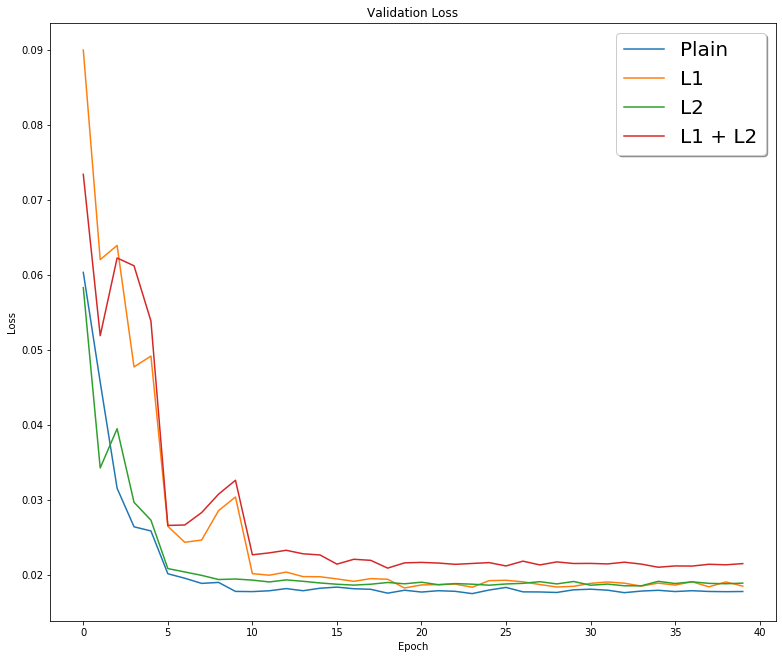

In [71]:
plot_metric(loss, l1_loss, l2_loss, l1_l2_loss, 'Loss')

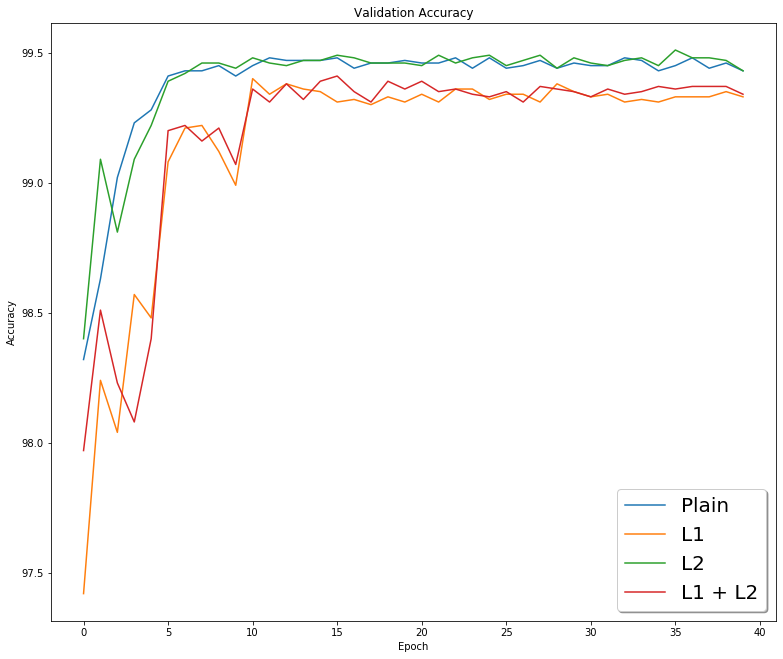

In [72]:
plot_metric(accuracy, l1_accuracy, l2_accuracy, l1_l2_accuracy, 'Accuracy')

In [0]:
from torchvision.utils import save_image
import pandas as pd
def save_and_show_result(data):

    # Initialize plot
    row_count = -1
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    fig.tight_layout()

    for idx, result in enumerate(data):

        # If 25 samples have been stored, break out of loop
        if idx > 24:
            break 
        label = result['label'].item()
        prediction = result['prediction'].item()

        # Plot image
        if idx % 5 == 0:
            row_count += 1
        axs[row_count][idx % 5].axis('off')
        axs[row_count][idx % 5].set_title(f'Label: {label}\nPrediction: {prediction}')
        axs[row_count][idx % 5].imshow(result['image'][0], cmap='gray_r')

# With out L1 and L2

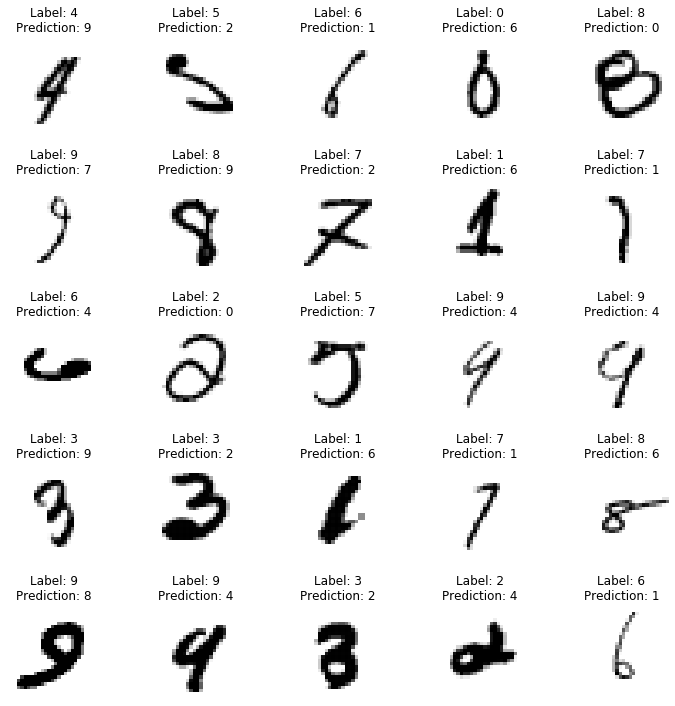

In [92]:
save_and_show_result(incorrect_pred)

#with L1 

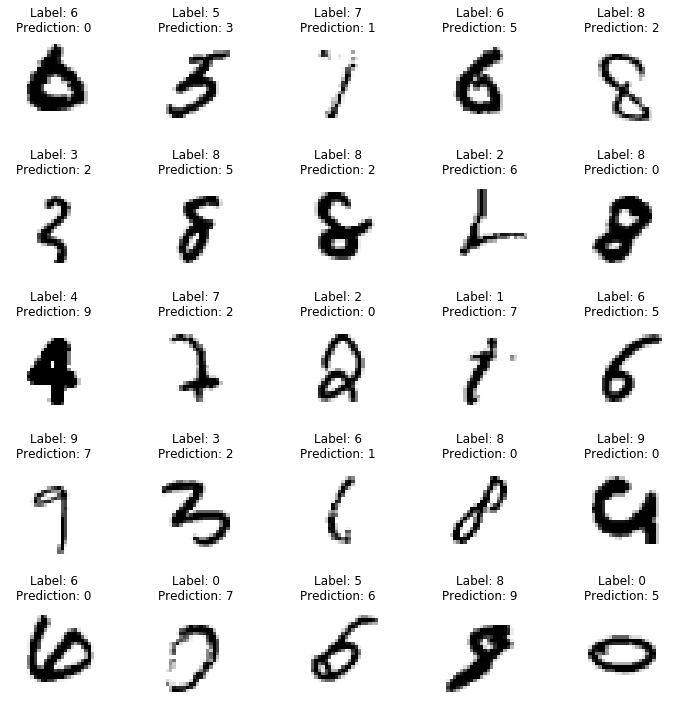

In [93]:
save_and_show_result(incorrect_pred_l1)

# with L2


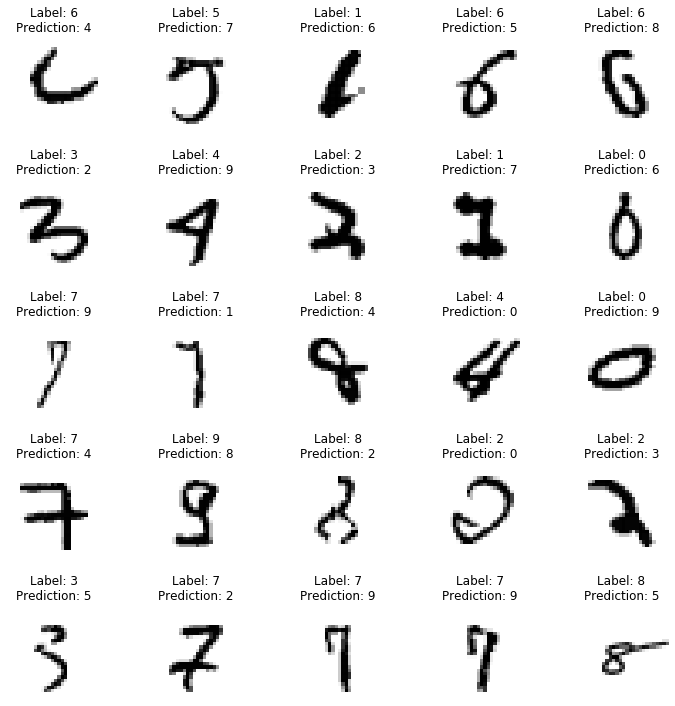

In [94]:
save_and_show_result(incorrect_pred_l2)

# with l1 and l2

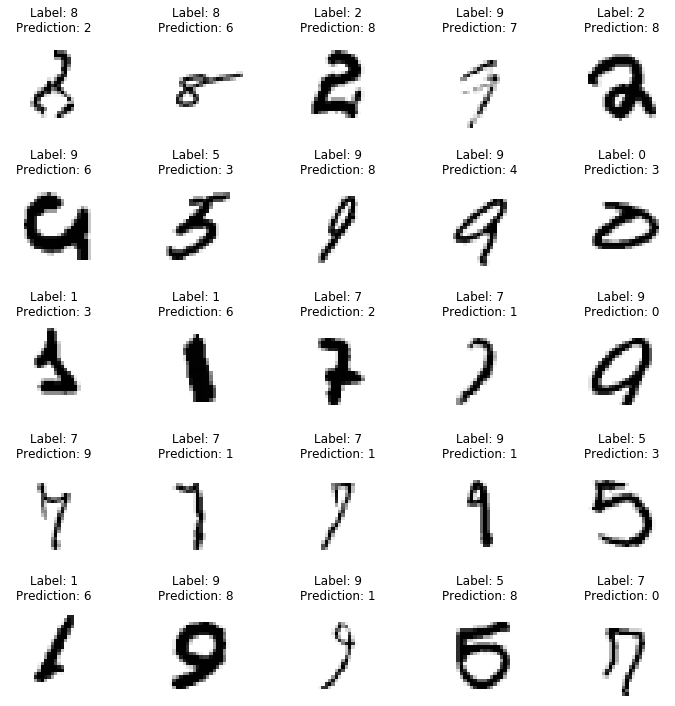

In [95]:
save_and_show_result(incorrect_pred_l1_l2)